In [1]:
import base64
from datetime import datetime, timedelta
import json
import os

from FH_Hydrosat import FH_Hydrosat
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj.crs import CRS
from pystac_client import Client
import seaborn as sns
from shapely.geometry import box, Point, Polygon

In [2]:
# Insitu point locations
insitu_met_points = {
    'Corn': [-121.5351, 38.1091],
    'Alfalfa': [-121.4993, 38.0992]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

aoi_bbox = {
    'Alfalfa': [-121.5365, 38.1098, -121.5355, 38.1091],
    'Corn': [-121.5027, 38.0986, -121.5003, 38.1000]
}

In [3]:
# Define function to process Ameriflux data
def read_ameriflux(data_path):
    df = pd.read_csv(data_path, header=2, na_values=[-9999])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

In [4]:
# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')
bi1_data_path = os.path.join(data_path, 
                             'AMF_US-Bi1_BASE-BADM_8-5',
                             'AMF_US-Bi1_BASE_HH_8-5.csv')

In [5]:
# Explore bi1 data
bi1_df = read_ameriflux(bi1_data_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')

Data range from 2016-08-13 00:00:00 to 2022-05-26 23:30:00


In [6]:
bi1_df.columns

Index(['end', 'TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'H2O', 'CH4', 'FC',
       'FCH4', 'FC_SSITC_TEST', 'FCH4_SSITC_TEST', 'G', 'H', 'LE',
       'H_SSITC_TEST', 'LE_SSITC_TEST', 'WD', 'WS', 'USTAR', 'ZL', 'TAU',
       'MO_LENGTH', 'V_SIGMA', 'W_SIGMA', 'TAU_SSITC_TEST_PI_F', 'PA', 'RH',
       'TA', 'VPD_PI', 'T_SONIC', 'T_SONIC_SIGMA', 'TS_1_1_1', 'TS_1_2_1',
       'TS_1_3_1', 'TS_1_4_1', 'TS_1_5_1', 'TS_2_1_1', 'TS_2_2_1', 'TS_2_3_1',
       'TS_2_4_1', 'TS_2_5_1', 'TS_3_1_1', 'TS_3_2_1', 'TS_3_3_1', 'TS_3_4_1',
       'TS_3_5_1', 'SWC_PI_1', 'SWC_PI_2', 'NETRAD', 'PPFD_IN', 'PPFD_OUT',
       'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P', 'FC_PI_F', 'RECO_PI_F',
       'GPP_PI_F', 'FCH4_PI_F', 'H_PI_F', 'LE_PI_F', 'SPEC_RED_IN',
       'SPEC_RED_OUT', 'SPEC_NIR_IN', 'SPEC_NIR_OUT', 'NDVI',
       'SPEC_PRI_TGT_IN', 'SPEC_PRI_TGT_OUT', 'SPEC_PRI_REF_IN',
       'SPEC_PRI_REF_OUT', 'PRI'],
      dtype='object')

<Axes: xlabel='start', ylabel='NDVI'>

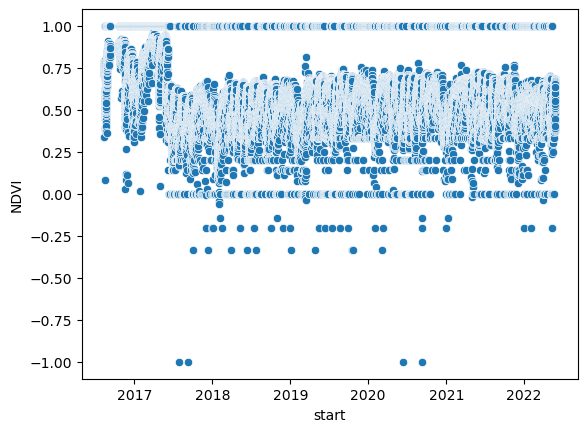

In [7]:
sns.scatterplot(bi1_df['NDVI'])

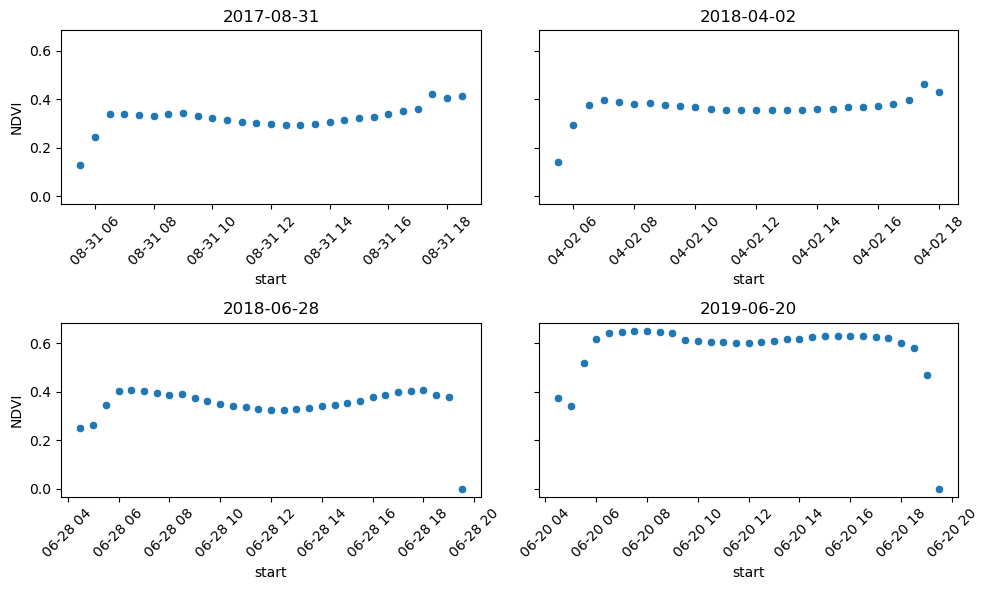

In [8]:
dates = ['2017-08-31', '2018-04-02', '2018-06-28', '2019-06-20']
fig, axes = plt.subplots(2,2, figsize=(10,6), sharey=True)
for date, ax in zip(dates, axes.flatten()):
    date_start = pd.to_datetime(date)
    date_end = date_start + timedelta(hours=24)
    filt = (bi1_df.index > date_start) &  (bi1_df.index < date_end)
    sns.scatterplot(bi1_df.loc[filt, 'NDVI'], ax=ax).set(title=date)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout();

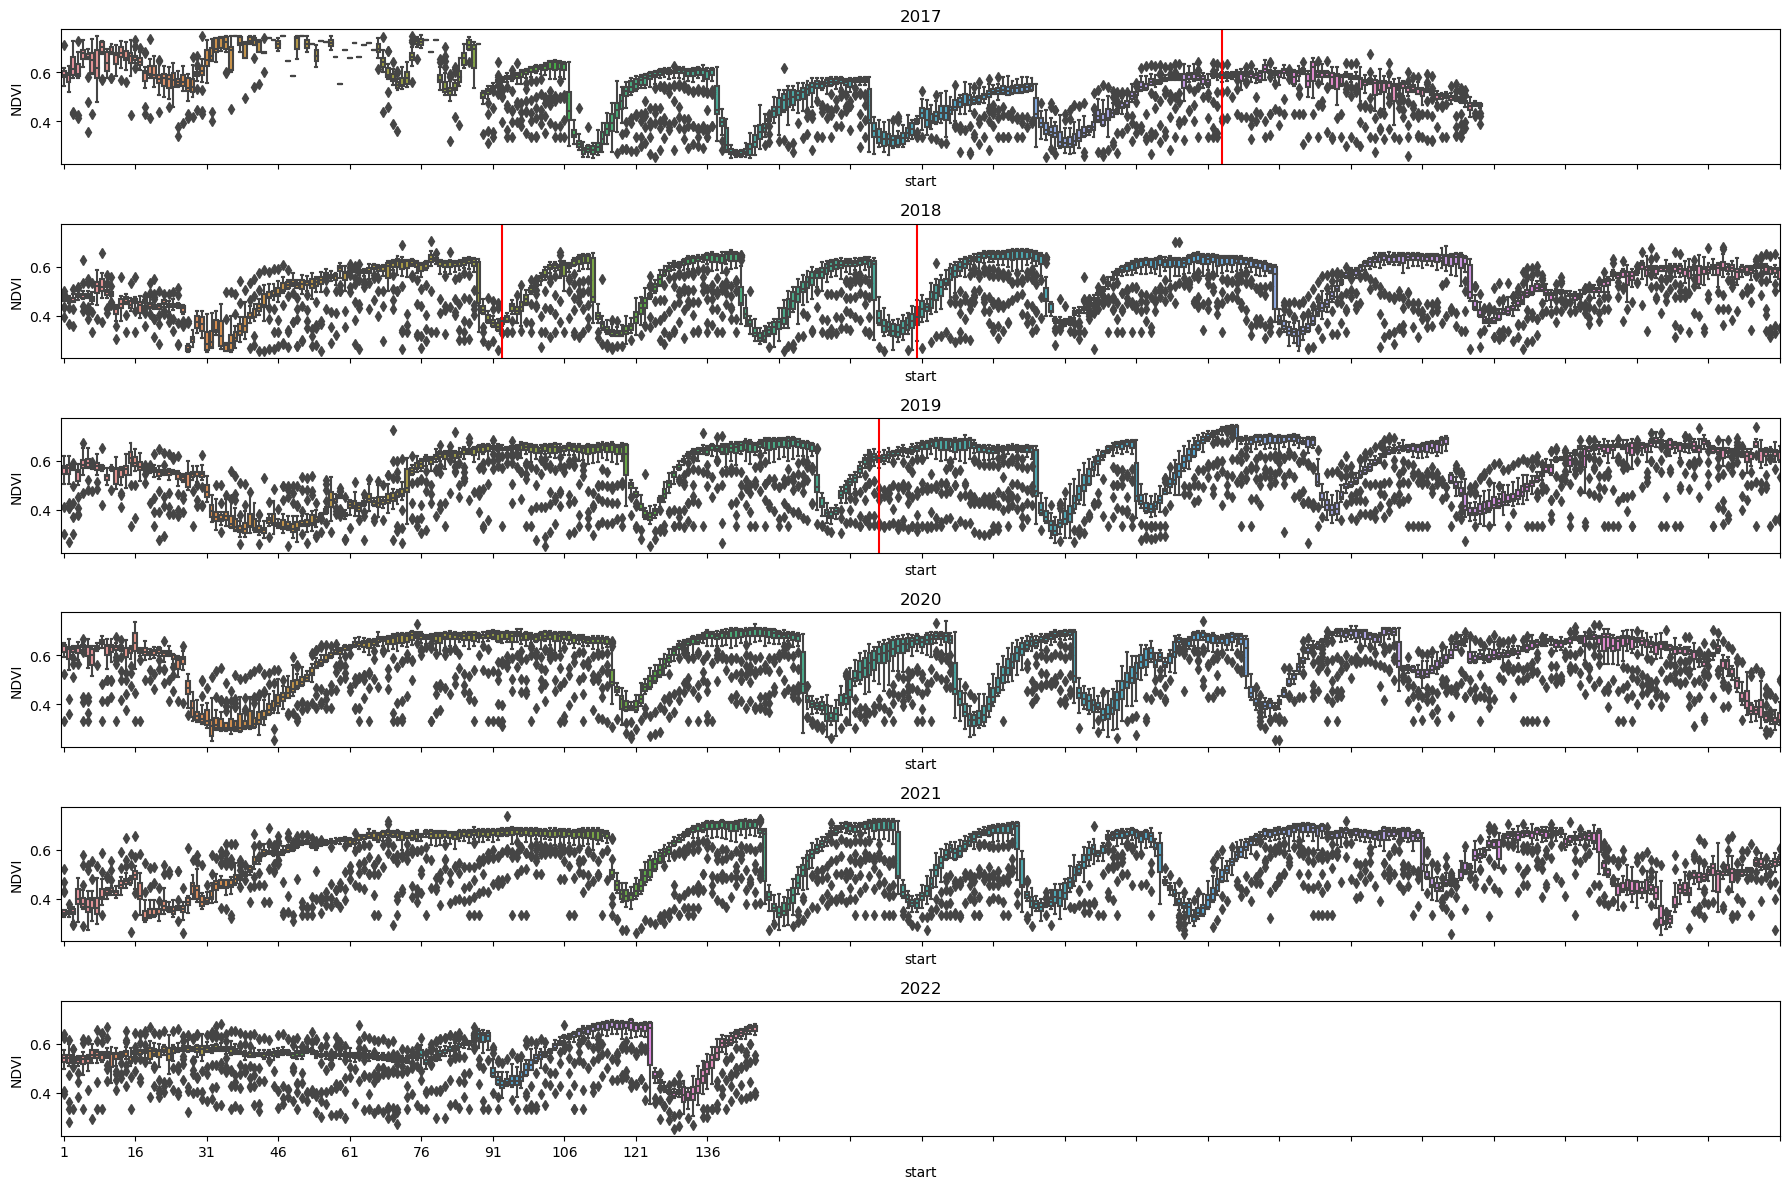

In [9]:
filt = (bi1_df['NDVI'] > 0.25) &  (bi1_df['NDVI'] < 0.75)
years = [2017, 2018, 2019, 2020, 2021, 2022]

fig, axes = plt.subplots(6, 1, figsize=(18, 12), sharex=True, sharey=True)
for year, ax in zip(years, axes.flatten()):
    df = bi1_df.loc[filt]
    df_year = df.loc[df.index.year == year]
    sns.boxplot(x=df_year.index.dayofyear,
                y=df_year['NDVI'],
                ax=ax).set(title=year)
    
    # df.loc[filt2].groupby(df_year.index.dayofyear)['NDVI'].mean().plot(ax=ax, color='k')
    plt.xticks(range(0,365,15))

axes.flatten()[0].axvline(x=pd.to_datetime(dates[0]).dayofyear, ymin=0, ymax=1, color='r')
axes.flatten()[1].axvline(x=pd.to_datetime(dates[1]).dayofyear, ymin=0, ymax=1, color='r')
axes.flatten()[1].axvline(x=pd.to_datetime(dates[2]).dayofyear, ymin=0, ymax=1, color='r')
axes.flatten()[2].axvline(x=pd.to_datetime(dates[3]).dayofyear, ymin=0, ymax=1, color='r')
plt.tight_layout();

In [10]:
# Authenticate and access catalog
with open(os.path.join('../secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [16]:
geom = {'type': 'Point', 'coordinates': crop_center_points['Alfalfa']}
start_date = "2016-08-13T00:00:00Z"
end_date = "2022-05-26T00:00:00Z"
pt = Point(geom['coordinates'])

In [17]:
collections_dict = {
    'collection': ['prepped_inputs_s2', 
                   'prepped_inputs_landsat', 
                   'prepped_inputs_mcd43a4', 
                   'prepped_inputs_mod21a1d',
                   'pydms_sharpened_modis',
                   'pydms_sharpened_landsat',
                   'starfm_predictions_modis_landsat'],
    'tolerance': [40, 60, 1000, 2000, 1000, 40, 40],
    'red_band': [2, 2, 0, 0, 0, 2, 2],
    'nir_band': [6, 6, 1,  1, 1, 6, 6]
}
collections_df = pd.DataFrame(collections_dict)
collections_df

,collection,tolerance,red_band,nir_band
0,prepped_inputs_s2,40,2,6
1,prepped_inputs_landsat,60,2,6
2,prepped_inputs_mcd43a4,1000,0,1
3,prepped_inputs_mod21a1d,2000,0,1
4,pydms_sharepend_modis,1000,0,1
5,pydms_sharpened_landsat,40,2,6
6,starfm_predictions_modis_landsat,40,2,6


In [18]:
def ndvi_from_collection(col_index, collections_df):
    search = catalog.search(
        collections=collections_df.iloc[col_index]['collection'],
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=500
    )

    s2_items = search.get_all_items()
    print(f'number of source {collections_df.iloc[col_index]["collection"]} items: {len(s2_items)}')

    assets = s2_items[0].to_dict()['assets'].keys()
    if len(s2_items) > 0 and 'surface_reflectance' in assets:
        res_full = FH_Hydrosat(s2_items, asset='surface_reflectance')
        res_dt = res_full.datetime
        tolerance = collections_df.iloc[col_index]['tolerance']
        red_band = collections_df.iloc[col_index]['red_band']
        nir_band = collections_df.iloc[col_index]['nir_band']

        red_ts = res_full.point_time_series_from_items(pt, tol=tolerance, nproc=6, band=red_band)
        nir_ts = res_full.point_time_series_from_items(pt, tol=tolerance, nproc=6, band=nir_band)

        ndvi_ts = (np.array(nir_ts) - np.array(red_ts)) / (np.array(nir_ts) + np.array(red_ts))
        ndvi_dt = res_dt

        ndvi_df = pd.DataFrame({'ndvi': ndvi_ts,
                                'datetime': pd.to_datetime(ndvi_dt)}).sort_values(by='datetime')
        ndvi_df.index = pd.to_datetime(ndvi_df['datetime'].dt.strftime('%Y-%m-%d'))

        ndvi_series = ndvi_df['ndvi']
        ndvi_series.name = collections_df.iloc[col_index]['collection']

        return ndvi_series

In [19]:
ndvi_results = []
for i in [0, 2]:  # TODO: allow for calculation of ndvi for all assets
    ndvi_series = ndvi_from_collection(i, collections_df)
    ndvi_results.append(ndvi_series)
ndvi_df = pd.concat(ndvi_results, axis=1)

number of source prepped_inputs_s2 items: 71
using 6 processes to sample 71 assets
using 6 processes to sample 71 assets
number of source prepped_inputs_mcd43a4 items: 488
using 6 processes to sample 488 assets
using 6 processes to sample 488 assets


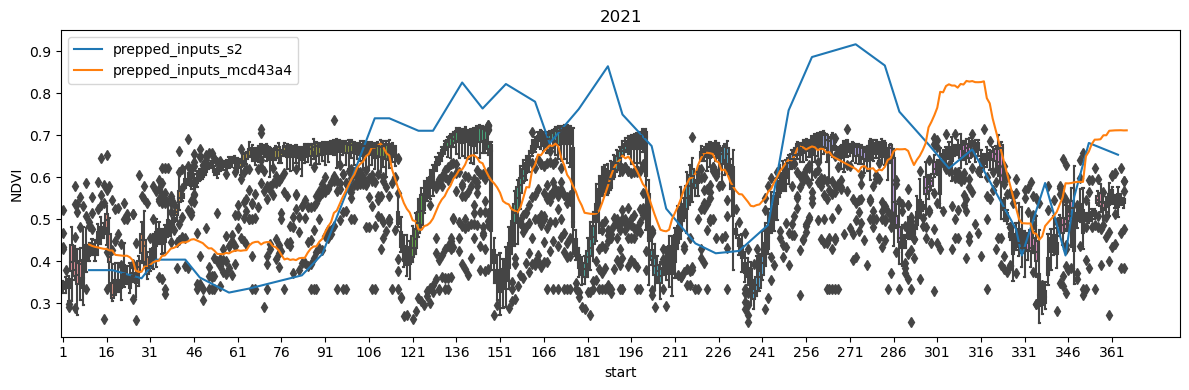

In [20]:
filt = (bi1_df['NDVI'] > 0.25) &  (bi1_df['NDVI'] < 0.75)
year = 2021

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df = bi1_df.loc[filt]
df_year = df.loc[df.index.year == year]
sns.boxplot(x=df_year.index.dayofyear,
            y=df_year['NDVI'],
            ax=ax).set(title=year)

ndvi_df_year = ndvi_df.loc[ndvi_df.index.year == year]
for col in ndvi_df_year.columns:
    sns.lineplot(x=ndvi_df_year.index.dayofyear,
            y=ndvi_df_year[col],
            ax=ax, label=col)

# df.loc[filt2].groupby(df_year.index.dayofyear)['NDVI'].mean().plot(ax=ax, color='k')
plt.xticks(range(0,365,15))
plt.tight_layout();